# Introduction

Find small single text files for **Language Modeling** experiements here ⬇️

https://www.kaggle.com/datasets/sovitrath/text-generation-language-modeling

In [1]:
import torch
import os
import numpy as np
import string
import re
import glob
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import tiktoken

from tqdm.auto import tqdm
from utils.text_gen import get_batch, train_step, val_step, NLPDataset
from collections import Counter
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim.lr_scheduler import StepLR
from attention.transformer_linear_decoder import Transformer

In [2]:
# Set seed.
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [3]:
!nvidia-smi

Tue Oct 17 06:43:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.182.03   Driver Version: 470.182.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   40C    P5    26W / 370W |    620MiB / 10009MiB |     16%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
CHECKPOINT_DIR = 'outputs/text_gen_simple_dec_imdb' 
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [5]:
dataset_dir = os.path.join('../../input', 'imdb_single_file', 'train')
train_file = os.listdir(dataset_dir)
print(train_file)

['imdb_train.txt']


## Prepare the Dataset
Let's find the longest review in the entire training set. As this will also contain the <br> tags, we will take the average of that.

We will pad the smaller sentences to this average length and truncate the longer sentences to the average length.

In [6]:
def find_longest_length(text_file_paths):
    """
    Find the longest review length in the entire training set. 

    :param text_file_paths: List, containing all the text file paths.

    Returns:
        max_len: Longest review length.
    """
    max_length = 0
    for path in text_file_paths:
        with open(path, 'r') as f:
            text = f.read()
            corpus = [
                word for word in text.split()
            ]
        if len(corpus) > max_length:
            max_length = len(corpus)
    return max_length


file_paths = []
file_paths.extend(glob.glob(os.path.join(
    dataset_dir, '*.txt'
)))
longest_sentence_length = find_longest_length(file_paths)
print(f"Total words (possibly, without tokenization): {longest_sentence_length} words")

Total words (possibly, without tokenization): 17566362 words


In [7]:
# Number of words to generate in a sentence.
SEQUENCE_LENGTH = 48
NUM_WORDS = 50257  # Vocabulary size.

# Batch size.
BATCH_SIZE = 16
VALID_SPLIT = 0.2
MAX_ITERS = 2500

### Helper Functions 

A few helper functions to prepare the dataset.

In [8]:
def find_word_frequency(
    text_file_paths, num_files, most_common=None
):
    """
    Create a list of tuples of the following format,
    [('ho', 2), ('hello', 1), ("let's", 1), ('go', 1)]
    where the number represents the frequency of occurance of 
    the word in the entire dataset.

    :param text_file_paths: List, containing all the text file paths.
    :param most_common: Return these many top words from the dataset.
        If `most_common` is None, return all. If `most_common` is 3,
        returns the top 3 tuple pairs in the list.

    Returns:
        sorted_words: A list of tuple containing each word and it's
        frequency of the format ('ho', 2), ('hello', 1), ...]
    """
    # Add all the words in the entire dataset to `corpus` list.
    corpus = []
    for i, path in enumerate(text_file_paths):
        if i+1 == num_files:
            break
        with open(path, 'r') as f:
            text = f.read()
            # Remove <br> tags.
            text = re.sub('<[^>]+>+', '', text)
            corpus.extend([
                word for word in text.split()
            ])
    count_words = Counter(corpus)
    # Create a dictionary with the most common word in the corpus 
    # at the beginning.
    # `word_frequency` will be like 
    word_frequency = count_words.most_common(n=most_common) # Returns all as n is `None`.
    return word_frequency

In [9]:
def word2int(input_words, num_words):
    """
    Create a dictionary of word to integer mapping for each unique word.

    :param input_words: A list of tuples containing the words and 
        theiry frequency. Should be of the following format,
        [('ho', 2), ('hello', 1), ("let's", 1), ('go', 1)]
    :param num_words: Number of words to use from the `input_words` list 
        to create the mapping. If -1, use all words in the dataset.

    Returns:
        int_mapping: A dictionary of word and a integer mapping as 
            key-value pair. Example, {'Hello,': 1, 'the': 2, 'let': 3}
    """

    if num_words > -1:
        int_mapping = {
            w:i+1 for i, (w, c) in enumerate(input_words) \
                if i <= num_words - 1 # -1 to avoid getting (num_words + 1) integer mapping.
        }
    else:
        int_mapping = {w:i+1 for i, (w, c) in enumerate(input_words)}
    return int_mapping

### Tiktoken

In [10]:
enc = tiktoken.encoding_for_model("gpt2")

## Prepare PyTorch Datasets and Data Loaders

In [11]:
file_paths = os.path.join(dataset_dir, train_file[0])

In [12]:
dataset_inst = NLPDataset(file_paths, enc)
dataset = dataset_inst.get_data()

In [13]:
print(f"Total tokens: {dataset.shape}")
print(f"Number of unique tokens: {len(np.unique(dataset))}")
# print(f"Number of chosen words to act as vocabulary (tokens): {len(int_mapping)}")

Total tokens: torch.Size([22667909])
Number of unique tokens: 45163


In [14]:
dataset_size = len(dataset)
# Calculate the validation dataset size.
valid_size = int(VALID_SPLIT*dataset_size)
# Radomize the data indices.
indices = torch.randperm(len(dataset)).tolist()
# Training and validation sets.
dataset_train = dataset[:-valid_size]
dataset_valid = dataset[-valid_size:]

# dataset_valid = NLPClassificationDataset()
print(f"Number of training samples: {len(dataset_train)}")
print(f"Number of validation samples: {len(dataset_valid)}")

Number of training samples: 18134328
Number of validation samples: 4533581


In [15]:
print(dataset_train.size(0))
print(dataset_valid.size(0))

18134328
4533581


In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
# for i, batch in enumerate(dataset_train):
#     inp, tgt = get_batch('train')
#     print(inp)
#     print(tgt)
#     inp_words = ''
#     tgt_words = ''
#     inp = inp[0].cpu().numpy()
#     tgt = tgt[0].cpu().numpy()
#     print(len(inp))
#     print(len(tgt))
#     for idx in inp:
#         inp_words += ' ' + int2word_train[idx]
#     print(inp_words)
#     print('*'*50)
#     for idx in tgt:
#         tgt_words += ' ' + int2word_train[idx]
#     print(tgt_words)
#     if i == 2:
#         break

## Model

In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model, dropout=0.1):
        """
        :param max_len: Input length sequence.
        :param d_model: Embedding dimension.
        :param dropout: Dropout value (default=0.1)
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Inputs of forward function
        :param x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """

        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)
    
class Embedding(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        """
        :param vocab_size: Size of vocabulary, an integer indicating
            the maximum unique words in the dataset.
        :param embed_dim: The embedding layer dimension.
        """
        super(Embedding, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim)
    
    def forward(self, x):
        """
        :param x: Input vector.
        
        Returns:
            out: Embedding vector.
        """
        out = self.embed(x)
        return out
    
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim=512, n_heads=8):
        """
        :param embed_dim: Embedding dimension.
        :param n_heads = Number of attention heads. 
        """
        super(MultiHeadAttention, self).__init__()

        self.embed_dim = embed_dim
        self.n_heads = n_heads
        assert embed_dim % n_heads == 0, \
            f"Embedding dimension should be divisible by number of heads"
        self.head_dim = int(self.embed_dim / self.n_heads)

        # Query matrix (64, 64).
        self.q = nn.Linear(self.head_dim, self.head_dim)
        # Key matrix (64, 64).
        self.k = nn.Linear(self.head_dim, self.head_dim)
        # Value matrix (64, 64).
        self.v = nn.Linear(self.head_dim, self.head_dim)

        self.out = nn.Linear(self.n_heads*self.head_dim, self.embed_dim)

    def forward(self, key, query, value, mask=None):
        """
        :param key: key vector.
        :param query: query vector.
        :param value: value vector.
        :param mask: Whether masking or not, for decoder.
        """
        batch_size = key.size(0) # Batch size.
        seq_len = key.size(1) # Max. sequence length.
        inp_emb = key.size(2) # Embedding dim.
        assert inp_emb == self.embed_dim, \
            f"Input embedding {inp_emb} should match layer embedding {self.embed_dim}"
        
        seq_len_query = query.size(1)

        key = key.view(
            batch_size, seq_len, self.n_heads, self.head_dim
        ) # [bs, seq_len, n_heads, head_dim] ~ [32, 1024, 8, 64]
        query = query.view(
            batch_size, seq_len_query, self.n_heads, self.head_dim
        ) # [bs, seq_len, n_heads, head_dim] ~ [32, 1024, 8, 64]
        value = value.view(
            batch_size, seq_len, self.n_heads, self.head_dim
        ) # [bs, seq_len, n_heads, head_dim] ~ [32, 1024, 8, 64]

        k = self.k(key)
        q = self.q(query)
        v = self.v(value)

        k = k.transpose(1, 2) # [batch_size, n_heads, seq_len, head_dim]
        q = q.transpose(1, 2) # [batch_size, n_heads, seq_len, head_dim]
        v = v.transpose(1, 2) # [batch_size, n_heads, seq_len, head_dim] 

        # Scaled-dot product attention.
        # Transposed key for matrix multiplication.
        k_transposed = k.transpose(-1, -2)
        dot = torch.matmul(q, k_transposed)
        if mask is not None:
            dot = dot.masked_fill(mask == 0, float('-1e20'))
        # Scaling.
        dot = dot / math.sqrt(self.head_dim) # / 64.
        scores = F.softmax(dot, dim=-1)
        # Dot product with value matix.
        scores = torch.matmul(scores, v)

        concat = scores.transpose(1,2).contiguous().view(
            batch_size, seq_len_query, self.head_dim*self.n_heads
        )

        out = self.out(concat)
        return out
    
class DecoderBlock(nn.Module):
    def __init__(self, embed_dim, expansion_factor=4, n_heads=8, dropout=0.3):
        """
        :param embed_dim: Embedding dimension.
        :param exansion_factor: Factor determining the feature dimension
            of linear layers.
        :param n_heads: Number of attention heads.
        """
        super(DecoderBlock, self).__init__()
        self.attention = MultiHeadAttention(embed_dim, n_heads)
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask=None, tgt_mask=None):    
        """
        :param key: Key vector.
        :param query: Query vector.
        :param mask: Mask for multi-head attention.

        Returns:
            out: Output of the transformer block.
        """
        attended = self.attention(x, x, x, mask=tgt_mask)
        x = self.dropout(self.norm(attended + x))
        attended = self.attention(enc_out, x, enc_out, mask=src_mask)
        out = self.dropout(self.norm(x + attended))
        return out
    
class TransformerDecoder(nn.Module):
    def __init__(
            self,
            tgt_vocab_size,
            embed_dim,
            seq_len, 
            num_layers=3,
            expansion_factor=4,
            n_heads=4,
            dropout=0.3
    ):
        """
        :param tgt_vocab_size: Target vocabuluary size.
        :param embed_dim: Embedding dimension.
        :param seq_len: Input sequence lenght.
        :param num_layers: Number of transformer layers.
        :param expansion_factor: Factor to determine the intermediate
            output feature dimension of linear layers.
        :param n_heads: Number of self attention heads.
        """
        super(TransformerDecoder, self).__init__()
        self.embedding = Embedding(tgt_vocab_size, embed_dim)
        self.postional_encoding = PositionalEncoding(seq_len, embed_dim)
        self.layers = nn.ModuleList(
            [
                DecoderBlock(embed_dim, expansion_factor, n_heads, dropout) \
                for _ in range(num_layers)
            ]
        )
        self.fc = nn.Linear(embed_dim, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, src_mask=None, tgt_mask=None):
        """
        :param x: Input target vector.
        :param enc_out: Encoder layer output.
        :param mask: Decoder self attention mask.

        Returns:
            out: Output vector.
        """
        x = self.embedding(x)
        x = self.postional_encoding(x)
        x = self.dropout(x)
        for layer in self.layers:
            x = layer(x, x, src_mask=None, tgt_mask=tgt_mask)
        out = self.fc(x)
        return out
    
class Transformer(nn.Module):
    def __init__(
            self,
            embed_dim, 
            tgt_vocab_size,
            seq_len,
            num_layers=6,
            expansion_factor=4,
            n_heads=8,
            dropout=0.3,
            device='cpu'
    ):
        """
        :param embed_dim: Embedding dimension.
        :param src_vocab_size: Source vocabulary size.
        :param tgt_vocab_size: Target vocabuluary size.
        :param seq_len: Input sequence lenght.
        :param num_layers: Number of transformer layers.
        :param expansion_factor: Factor to determine the intermediate
            output feature dimension of linear layers.
        :param n_heads: Number of self attention heads.
        """
        super(Transformer, self).__init__()
        self.tgt_vocab_size = tgt_vocab_size
        self.decoder = TransformerDecoder(
            tgt_vocab_size,
            embed_dim,
            seq_len,
            num_layers,
            expansion_factor,
            n_heads,
            dropout
        )
        self.device=device
        
    def make_tgt_mask(self, tgt, pad_token_id=1):
        """
        :param tgt: Target sequence.
        :param pad_token_id: Padding token ID, default 1.
        Returns:
            tgt_mask: Target mask.
        """
        batch_size = tgt.shape[0]
        device = tgt.device
        # Some help from here:
        # https://github.com/gordicaleksa/pytorch-original-transformer/blob/main/utils/data_utils.py
        # Same as src_mask but we additionally want to mask tokens from looking forward into the future tokens
        # Note: wherever the mask value is true we want to attend to that token, otherwise we mask (ignore) it.
        sequence_length = tgt.shape[1]  # trg_token_ids shape = (B, T) where T max trg token-sequence length
        trg_padding_mask = (tgt != pad_token_id).view(batch_size, 1, 1, -1)  # shape = (B, 1, 1, T)
        trg_no_look_forward_mask = torch.triu(torch.ones((
            1, 1, sequence_length, sequence_length), device=device
        ) == 1).transpose(2, 3)

        # logic AND operation (both padding mask and no-look-forward must be true to attend to a certain target token)
        tgt_mask = trg_padding_mask & trg_no_look_forward_mask  # final shape = (B, 1, T, T)
        return tgt_mask
            
    def forward(self, tgt):
        """
        :param src: Encoder input.
        :param tgt: Decoder input

        Returns:
            out: Output vector containing probability of each token.
        """
        tgt_mask = self.make_tgt_mask(tgt).cuda()
        out = self.decoder(tgt, tgt, tgt_mask, tgt_mask=tgt_mask)
        return out

In [19]:
model = Transformer(
    embed_dim=1024, 
    tgt_vocab_size=NUM_WORDS, 
    seq_len=SEQUENCE_LENGTH,
    num_layers=6, 
    expansion_factor=4, 
    n_heads=16,
)

In [20]:
_ = model.to(device)

## Training

In [21]:
print(model)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(), 
    lr=0.0001,
)

# StepLR every specific number of epochs.
scheduler = StepLR(
    optimizer, 
    step_size=5, 
    gamma=0.5,
    verbose=True
)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

Transformer(
  (decoder): TransformerDecoder(
    (embedding): Embedding(
      (embed): Embedding(50257, 1024)
    )
    (postional_encoding): PositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-5): 6 x DecoderBlock(
        (attention): MultiHeadAttention(
          (q): Linear(in_features=64, out_features=64, bias=True)
          (k): Linear(in_features=64, out_features=64, bias=True)
          (v): Linear(in_features=64, out_features=64, bias=True)
          (out): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.3, inplace=False)
      )
    )
    (fc): Linear(in_features=1024, out_features=50257, bias=True)
    (dropout): Dropout(p=0.3, inplace=False)
  )
)
Adjusting learning rate of group 0 to 1.0000e-04.
109,361,361 total parameters.
109,361,361 training parameters.



In [22]:
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
# Start the training.
for iteration in range(MAX_ITERS):
    train_step_loss = train_step(
        model, 
        dataset_train, 
        optimizer, 
        criterion,
        SEQUENCE_LENGTH,
        NUM_WORDS,
        BATCH_SIZE,
        device
    )
    valid_step_loss = val_step(
        model, 
        dataset_valid,  
        criterion,
        SEQUENCE_LENGTH,
        NUM_WORDS,
        BATCH_SIZE,
        device
    )
    train_loss.append(train_step_loss.cpu().detach().numpy())
    valid_loss.append(valid_step_loss.cpu().detach().numpy())
    if iteration % 250 == 0:
        print(f"[INFO]: Iteration {iteration+1} of {MAX_ITERS}")
        print(f"Training loss: {train_step_loss}")
        print(f"Validation loss: {valid_step_loss}")
        print('-'*50)
    #     if epoch + 1 <= 32:
#         scheduler.step()
# Save model.
torch.save(
    model, os.path.join(CHECKPOINT_DIR, 'model.pth')
)

[INFO]: Iteration 1 of 2500
Training loss: 11.112164497375488
Validation loss: 10.829601287841797
--------------------------------------------------
[INFO]: Iteration 251 of 2500
Training loss: 7.466793537139893
Validation loss: 7.473602771759033
--------------------------------------------------
[INFO]: Iteration 501 of 2500
Training loss: 7.556978225708008
Validation loss: 7.285558700561523
--------------------------------------------------
[INFO]: Iteration 751 of 2500
Training loss: 7.264347553253174
Validation loss: 7.106607913970947
--------------------------------------------------
[INFO]: Iteration 1001 of 2500
Training loss: 7.38055419921875
Validation loss: 7.133108139038086
--------------------------------------------------
[INFO]: Iteration 1251 of 2500
Training loss: 7.274848937988281
Validation loss: 7.492506504058838
--------------------------------------------------
[INFO]: Iteration 1501 of 2500
Training loss: 7.119042873382568
Validation loss: 7.361042499542236
------

In [23]:
# Save model.
torch.save(
    model, os.path.join(CHECKPOINT_DIR, 'model.pth')
)

In [24]:
def save_plots(train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    plt.show()
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='blue', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
#     plt.savefig(f"../outputs/loss.png")
    plt.show()

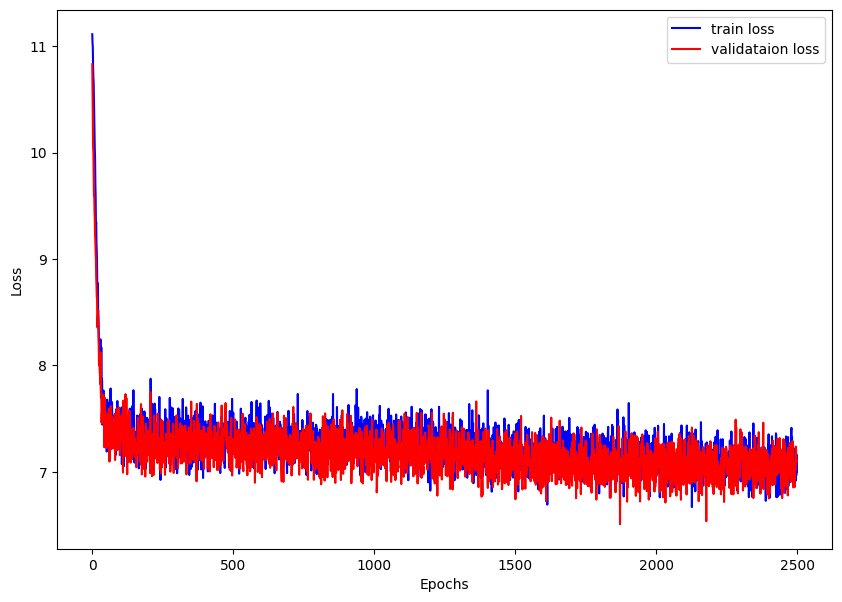

In [25]:
save_plots(train_loss, valid_loss)

## Test Model

In [26]:
trained_model = torch.load(
    os.path.join(CHECKPOINT_DIR, 'model.pth')
)

In [27]:
# test_loss = validate(
#     trained_model, 
#     dataset_test,  
#     criterion, 
#     device
# )

# print(f"Test loss: {test_loss}")

## Text Generation

In [28]:
def return_int_vector(enc, text):
        """
        Assign an integer to each word and return the integers in a list.
        """
        return enc.encode(text)

In [29]:
enc = tiktoken.encoding_for_model("gpt2")

In [30]:
# def sample_next(predictions, temperature=1.0):
#     """
#     Implement variable-temperature sampling from a probability
#     distribution.
#     """
#     predictions = predictions.squeeze(0)[-1, :] / temperature
#     predictions = predictions.exp().cpu()
#     next_token = torch.multinomial(predictions, num_samples=1)
#     return int(next_token[0].cpu())

# def text_generator(sentence, generate_length):
#     trained_model.eval()
#     temperatures = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] 
#     for temperature in temperatures:
#         sample = sentence
#         print(f"GENERATED SENTENCE WITH TEMPERATURE {temperature}")
#         for i in range(generate_length):
#             int_vector = return_int_vector(enc, sample)
#             if len(int_vector) >= SEQUENCE_LENGTH - 1:
#                 break
#             input_tensor = torch.tensor(int_vector, dtype=torch.int32)
#             input_tensor = input_tensor.unsqueeze(0).to(device)
#             with torch.no_grad():
#                 predictions = trained_model(input_tensor)
#             next_token = sample_next(predictions, temperature)
# #             if next_token != 0: # Ignore <pad> index. Final sentence may be shorter.
#             sample += enc.decode([next_token])
#         print(sample)
#         print('\n')


# def sample_next(predictions, temperature=1.0):
#     """
#     Implement variable-temperature sampling from a probability distribution.
#     """
#     # Get the last predicted token for the batch, assuming predictions shape is [1, sequence_length, vocab_size]
#     logits = predictions[0, -1, :]
#     # Divide logits by temperature to adjust sharpness
#     logits /= temperature
#     # Apply softmax to get probabilities
#     probabilities = F.softmax(logits, dim=-1).cpu()
#     # Sample from the multinomial distribution
#     next_token = torch.multinomial(probabilities, num_samples=1)
#     return int(next_token[0].cpu())

def sample_next(predictions, temperature=1.0):
    """
    Implement variable-temperature sampling from a probability
    distribution.
    """
    # print(predictions.shape)
    predictions = predictions[:, -1, :] / temperature
    # print(predictions.shape)
    # print(torch.where(predictions > 0))
    probabilities = F.softmax(predictions, dim=-1).cpu()
    # print(probabilities.shape)
    next_token = torch.multinomial(probabilities, num_samples=1)
    # print(next_token)
    return int(next_token.cpu())

def text_generator(sentence, generate_length):
    trained_model.eval()
    temperatures = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0] 
    for temperature in temperatures:
        sample = sentence
        print(f"GENERATED SENTENCE WITH TEMPERATURE {temperature}")
        for i in range(generate_length):
            # print(f"Sample: {sample}")
            int_vector = return_int_vector(enc, sample)
            if len(int_vector) >= SEQUENCE_LENGTH - 1:
                break
            input_tensor = torch.tensor(int_vector, dtype=torch.long).to(device)  # Changed dtype to torch.long
            input_tensor = input_tensor.unsqueeze(0)
            with torch.no_grad():
                predictions = trained_model(input_tensor)
            next_token = sample_next(predictions, temperature)  # Pass the temperature to the sample function
            sample += enc.decode([next_token])
        print(sample)
        print('\n')

In [31]:
sentences = [
    "Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as Teachers"
]

In [32]:
generate_length = 100

In [33]:
for sentence in sentences:
    print(f"PROMPT: {sentence}")
    text_generator(sentence, generate_length)
    print('\n############\n')

PROMPT: Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as Teachers
GENERATED SENTENCE WITH TEMPERATURE 0.1
Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as Teachers,,,, a a a a a a a a a a a a a a a a a a a a


GENERATED SENTENCE WITH TEMPERATURE 0.2
Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as Teachers is is is is is is is is is is is is is is is is is is is is is


GENERATED SENTENCE WITH TEMPERATURE 0.3
Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as Teachers is is is is is is is is is is is is is is is is is is is is is


GENERATED SENTENCE WITH TEMPERATURE 0.4
Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as Teachers a a a a a a a a a a a a a a a a a a a a a


GENERATED SENTENCE WIT